In [1]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# read in all raw data

# path to the file with all paths to files
paths = "/home/flavia/Projects/Funding-Landscape/code/supporting-files/directories-path/titles-abstracts-dir-STEM.txt"

# read file with all paths to files
paths_df = pd.read_csv(paths, names = ["fn","FundingBody"], delimiter= " ")

# create empty lists to store number of documents and country name
n_docs = []
country = []

# for line in file with paths to files
for fn in paths_df["fn"]:
    # count the number of lines in each file (each line is a separate document)
    n_docs.append(sum(1 for line in open(fn)))
    # get the name of the country (index 7/position 6) from the file path (line)
    country.append(fn.split("/")[7])

# store number of lines and country name 
paths_df["n_docs"] = n_docs
paths_df["country"] = country

paths_df.agg({"n_docs":"sum"})

n_docs    2985010
dtype: int64

In [3]:
processed_text = pd.read_csv("/home/flavia/Projects/Funding-Landscape/clean-data/fine-scale/STEM/titles-abstracts-tokenized.csv", delimiter=" ", header=None, names = ["ProjectId","Label", "Tokens"])
processed_text["n_Tokens"] = processed_text["Tokens"].apply(lambda x: len(str(x).split(" ")))

filtered_text = pd.read_csv("/home/flavia/Projects/Funding-Landscape/clean-data/fine-scale/STEM/titles-abstracts-tokenized-filtered.csv", delimiter=" ", header=None, names = ["ProjectId","Label", "Tokens"])
filtered_text["n_Tokens"] = filtered_text["Tokens"].apply(lambda x: len(str(x).split(" ")))

In [4]:
print("number of documents in raw data:", paths_df.agg({"n_docs":"sum"})[0])
print("number of documents in processed data (tokenising/removing stopwords and words smaller than 3 characters): ", processed_text.shape[0])
print("number of documents in filtered data (documents with less than 5 tokens): ", filtered_text.shape[0])


number of documents in raw data: 2985010
number of documents in processed data (tokenising/removing stopwords and words smaller than 3 characters):  1133318
number of documents in filtered data (documents with less than 5 tokens):  942520


<AxesSubplot:xlabel='n_Tokens', ylabel='Count'>

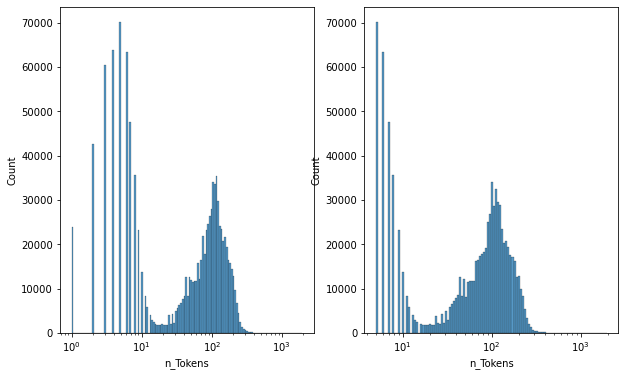

In [5]:
f, ax = plt.subplots(figsize=(10, 6),ncols=2)
ax[0].set(xscale="log")
ax[1].set(xscale="log")

sns.histplot(data = processed_text, x = "n_Tokens",ax=ax[0])
sns.histplot(data = filtered_text, x = "n_Tokens",ax=ax[1])

## Distances between topic models 
(100, 200, 300, 400 topics)

In [6]:
# load data
tsne_100 = pd.read_csv("/home/flavia/Projects/Funding-Landscape/results/fine-scale/tSNE/100-topics-TSNE.csv", index_col= False)
tsne_150 = pd.read_csv("/home/flavia/Projects/Funding-Landscape/results/fine-scale/tSNE/150-topics-TSNE.csv", index_col= False)
tsne_200 = pd.read_csv("/home/flavia/Projects/Funding-Landscape/results/fine-scale/tSNE/200-topics-TSNE.csv", index_col= False)
tsne_300 = pd.read_csv("/home/flavia/Projects/Funding-Landscape/results/fine-scale/tSNE/300-topics-TSNE.csv", index_col= False)
tsne_400 = pd.read_csv("/home/flavia/Projects/Funding-Landscape/results/fine-scale/tSNE/400-topics-TSNE.csv", index_col= False)

/tmp/ipykernel_172674/3263812283.py:2: DtypeWarning: Columns (106,107) have mixed types. Specify dtype option on import or set low_memory=False.
  tsne_100 = pd.read_csv("/home/flavia/Projects/Funding-Landscape/results/fine-scale/tSNE/100-topics-TSNE.csv", index_col= False)
/tmp/ipykernel_172674/3263812283.py:3: DtypeWarning: Columns (155,156,157) have mixed types. Specify dtype option on import or set low_memory=False.
  tsne_150 = pd.read_csv("/home/flavia/Projects/Funding-Landscape/results/fine-scale/tSNE/150-topics-TSNE.csv", index_col= False)
/tmp/ipykernel_172674/3263812283.py:4: DtypeWarning: Columns (205,206,207) have mixed types. Specify dtype option on import or set low_memory=False.
  tsne_200 = pd.read_csv("/home/flavia/Projects/Funding-Landscape/results/fine-scale/tSNE/200-topics-TSNE.csv", index_col= False)
/tmp/ipykernel_172674/3263812283.py:5: DtypeWarning: Columns (305,306,307,309) have mixed types. Specify dtype option on import or set low_memory=False.
  tsne_300 = p

In [7]:
# look at dimensions of dataframes
print("Model with 100 topics shape:", tsne_100.shape)
print("Model with 150 topics shape:", tsne_150.shape)
print("Model with 200 topics shape:", tsne_200.shape)
print("Model with 300 topics shape:", tsne_300.shape)
print("Model with 400 topics shape:", tsne_400.shape)

Model with 100 topics shape: (754461, 118)
Model with 150 topics shape: (754461, 168)
Model with 200 topics shape: (754461, 218)
Model with 300 topics shape: (754461, 318)
Model with 400 topics shape: (754461, 418)


In [8]:
tsne_150.iloc[:, [151, 152]]
tsne_150.iloc[:, [1,2,151,152]]

ProjectId         2       151    Country
0        LS/2022/167  0.000050  0.000062  Australia
1        CS/2020/191  0.000055  0.000068  Australia
2       WAC/2021/164  0.000064  0.000079  Australia
3       WAC/2020/180  0.000097  0.210046  Australia
4       FST/2021/145  0.000082  0.000101  Australia
...              ...       ...       ...        ...
754456   NSF-0542848  0.000099  0.000121        USA
754457   NSF-2023186  0.001202  0.000051        USA
754458   NSF-1948409  0.000044  0.000055        USA
754459   NSF-1714753  0.000078  0.146770        USA
754460   NSF-0223753  0.000244  0.000300        USA

[754461 rows x 4 columns]

In [9]:
# calculate distances
from scipy.spatial.distance import cdist 

def get_distances(df, projectId, Nmax):
    #calculate distances
    # get df subset
    df_sub = df[df["ProjectId"].isin(projectId)]
    #get probs
    probs = np.array(df_sub.iloc[:, range(2,Nmax)])
    #calculate distances
    d_mat = cdist(probs,probs, 'euclid')

    return(d_mat)

#sample of project IDs
Project_sample = tsne_100.sample(n = 5000)["ProjectId"]

d100 = get_distances(tsne_100, Project_sample, 102)
d150 = get_distances(tsne_150, Project_sample, 152)
d200 = get_distances(tsne_200, Project_sample, 202)
d300 = get_distances(tsne_300, Project_sample, 302)
d400 = get_distances(tsne_400, Project_sample, 402)


In [10]:
# look at dimensions of dataframes
print("Model with 100 topics shape:", d100.shape)
print("Model with 150 topics shape:", d150.shape)
print("Model with 200 topics shape:", d200.shape)
print("Model with 300 topics shape:", d300.shape)
print("Model with 400 topics shape:", d400.shape)

Model with 100 topics shape: (5000, 5000)
Model with 150 topics shape: (5000, 5000)
Model with 200 topics shape: (5000, 5000)
Model with 300 topics shape: (5000, 5000)
Model with 400 topics shape: (5000, 5000)


[Text(0.5, 0, '300 topics'), Text(0, 0.5, '400 topics')]

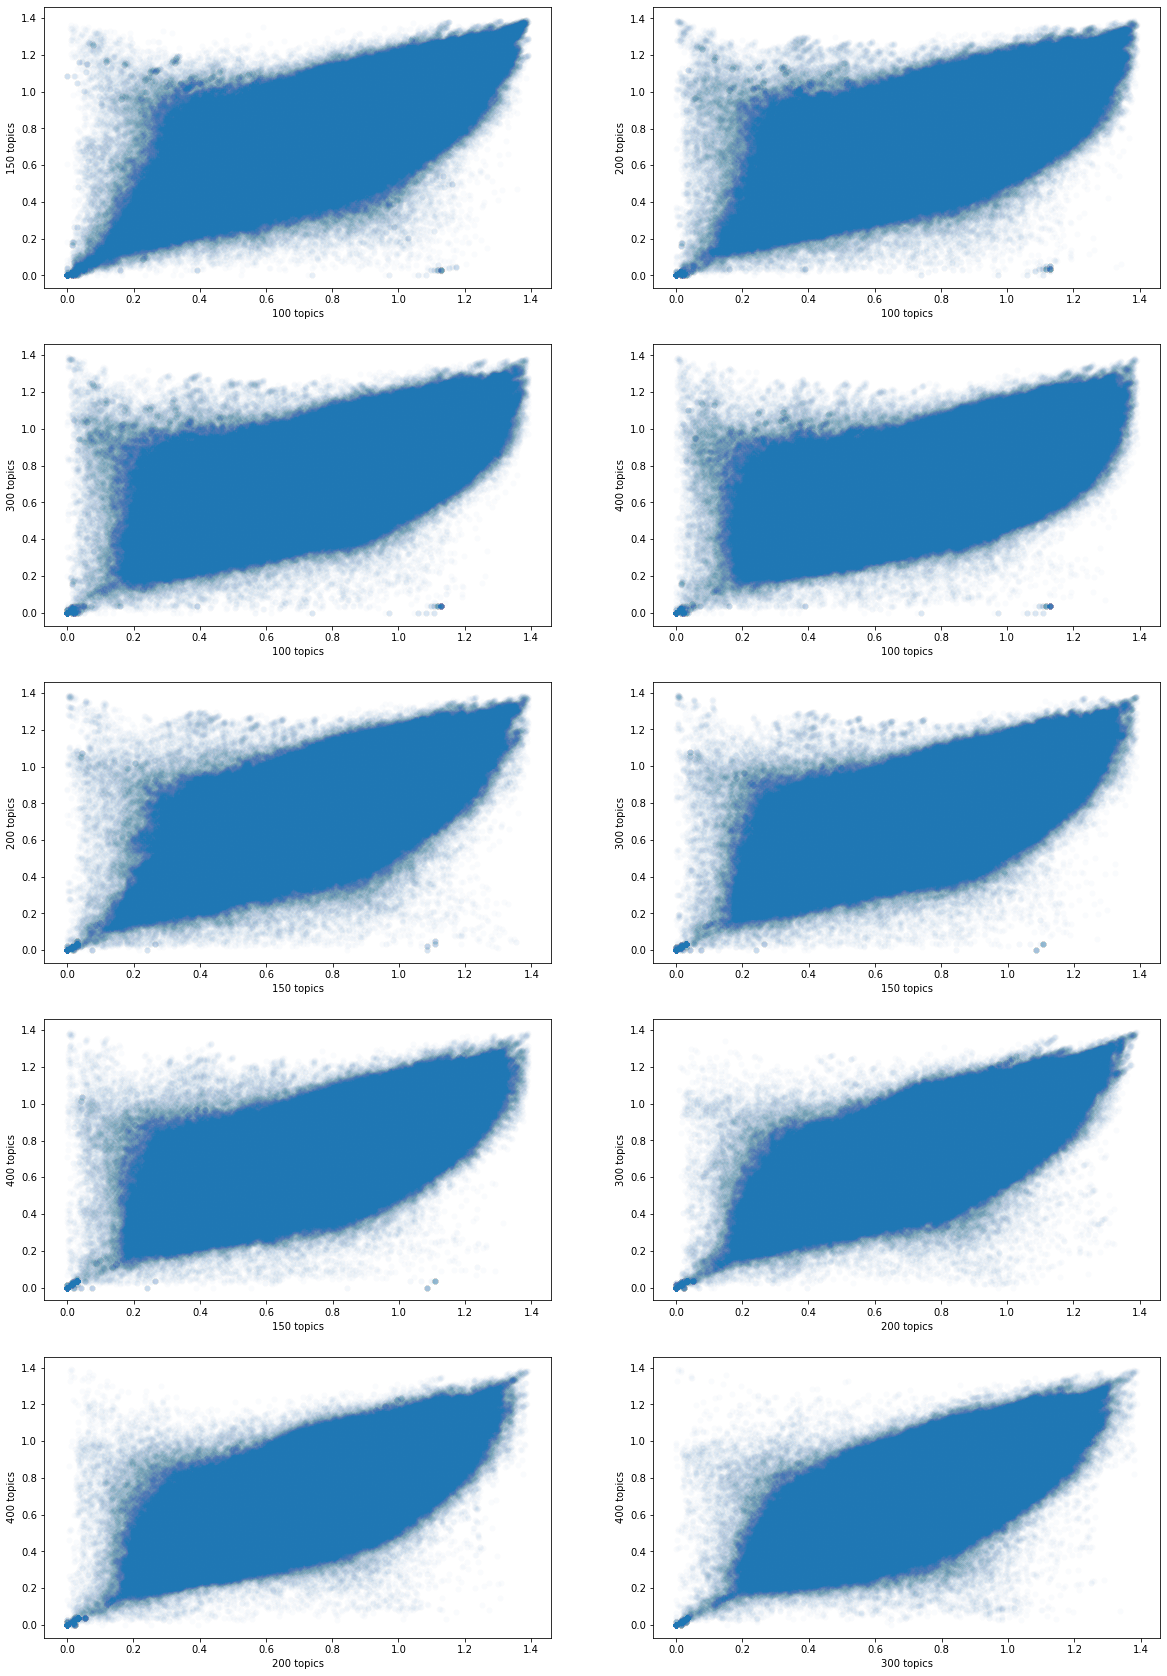

In [11]:
# plot
f, ax = plt.subplots(figsize=(20, 30),ncols=2, nrows=5)
p = sns.scatterplot(x = d100.flatten(), y = d150.flatten(), alpha = 0.01, ax=ax[0,0])
p.set(xlabel='100 topics', ylabel = '150 topics')
p = sns.scatterplot(x = d100.flatten(), y = d200.flatten(), alpha = 0.01, ax=ax[0,1])
p.set(xlabel='100 topics', ylabel = '200 topics')
p = sns.scatterplot(x = d100.flatten(), y = d300.flatten(), alpha = 0.01, ax=ax[1,0])
p.set(xlabel='100 topics', ylabel = '300 topics')
p = sns.scatterplot(x = d100.flatten(), y = d400.flatten(), alpha = 0.01, ax=ax[1,1])
p.set(xlabel='100 topics', ylabel = '400 topics')
p = sns.scatterplot(x = d150.flatten(), y = d200.flatten(), alpha = 0.01, ax=ax[2,0])
p.set(xlabel='150 topics', ylabel = '200 topics')
p = sns.scatterplot(x = d150.flatten(), y = d300.flatten(), alpha = 0.01, ax=ax[2,1])
p.set(xlabel='150 topics', ylabel = '300 topics')
p = sns.scatterplot(x = d150.flatten(), y = d400.flatten(), alpha = 0.01, ax=ax[3,0])
p.set(xlabel='150 topics', ylabel = '400 topics')
p = sns.scatterplot(x = d200.flatten(), y = d300.flatten(), alpha = 0.01, ax=ax[3,1])
p.set(xlabel='200 topics', ylabel = '300 topics')
p = sns.scatterplot(x =d200.flatten(), y = d400.flatten(), alpha = 0.01, ax=ax[4,0])
p.set(xlabel='200 topics', ylabel = '400 topics')
p = sns.scatterplot(x =d300.flatten(), y = d400.flatten(), alpha = 0.01, ax=ax[4,1])
p.set(xlabel='300 topics', ylabel = '400 topics')


## TSNE

In [12]:
tsne_100["Topic"] = tsne_100.iloc[:, range(2,102)].idxmax(axis = "columns")
tsne_150["Topic"] = tsne_150.iloc[:, range(2,152)].idxmax(axis = "columns")
tsne_200["Topic"] = tsne_200.iloc[:, range(2,202)].idxmax(axis = "columns")
tsne_300["Topic"] = tsne_300.iloc[:, range(2,302)].idxmax(axis = "columns")
tsne_400["Topic"] = tsne_400.iloc[:, range(2,402)].idxmax(axis = "columns")

In [13]:
# pivot long the data frame to get a column with the tsne perplexities
tsne_100_long = pd.melt(tsne_100, id_vars=['ProjectId','Topic'], value_vars=["TSNE_1_30", "TSNE_2_30","TSNE_1_50","TSNE_2_50","TSNE_1_70","TSNE_2_70", "TSNE_1_90","TSNE_2_90"])
# split column name by '_' 
tsne_100_long[['TSNE', 'TSNE_axis', 'perplexity']] = tsne_100_long.variable.str.split("_", expand=True)
# drop column created by the first "_" in split
tsne_100_long = tsne_100_long.drop(columns='TSNE')
# pivot wide the dataframe to get axes
tsne_100_wide = pd.pivot(tsne_100_long, index = ['ProjectId', 'Topic', 'perplexity'], columns='TSNE_axis', values='value').reset_index()
# rename axes
tsne_100_wide= tsne_100_wide.rename(columns={'1':'Axis_1', '2':'Axis_2'})
# look at final df
tsne_100_wide.head()

TSNE_axis     ProjectId Topic perplexity    Axis_1    Axis_2
0          ADP/2012/107    74         30  3.139507  1.041965
1          ADP/2012/107    74         50  2.891762  2.111330
2          ADP/2012/107    74         70  2.864776  2.828729
3          ADP/2012/107    74         90  3.072198  3.629943
4          ADP/2014/045    74         30  3.828092  1.653053

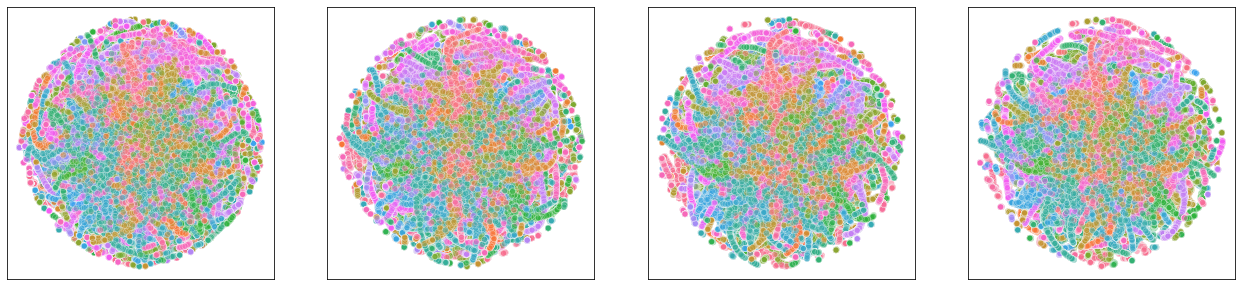

In [14]:
# plot perplexities for model with 100 topics
f, ax = plt.subplots(figsize=(22, 5), ncols= 4)

for i in range(4):
    df = tsne_100_wide.query("perplexity == '" + str([30,50,70,90][i]) + "'")
    g = sns.scatterplot(y="Axis_1", x="Axis_2", alpha=.5, hue= 'Topic', data = df, ax = ax[i])
    g.legend_.remove()
    g.tick_params(bottom = False, left = False)
    g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)

In [15]:
# pivot long the data frame to get a column with the tsne perplexities
tsne_150_long = pd.melt(tsne_150, id_vars=['ProjectId','Topic'], value_vars=["TSNE_1_30", "TSNE_2_30","TSNE_1_50","TSNE_2_50","TSNE_1_70","TSNE_2_70", "TSNE_1_90","TSNE_2_90"])
# split column name by '_' 
tsne_150_long[['TSNE', 'TSNE_axis', 'perplexity']] = tsne_150_long.variable.str.split("_", expand=True)
# drop column created by the first "_" in split
tsne_150_long = tsne_150_long.drop(columns='TSNE')
# pivot wide the dataframe to get axes
tsne_150_wide = pd.pivot(tsne_150_long, index = ['ProjectId', 'Topic', 'perplexity'], columns='TSNE_axis', values='value').reset_index()
# rename axes
tsne_150_wide= tsne_150_wide.rename(columns={'1':'Axis_1', '2':'Axis_2'})
# look at final df
tsne_150_wide.head()

TSNE_axis     ProjectId Topic perplexity    Axis_1    Axis_2
0          ADP/2012/107    47         30 -3.578896 -9.108447
1          ADP/2012/107    47         50 -4.517320 -8.446754
2          ADP/2012/107    47         70 -4.616269 -8.455676
3          ADP/2012/107    47         90 -5.576587 -6.670705
4          ADP/2014/045    41         30  5.185884  3.767476

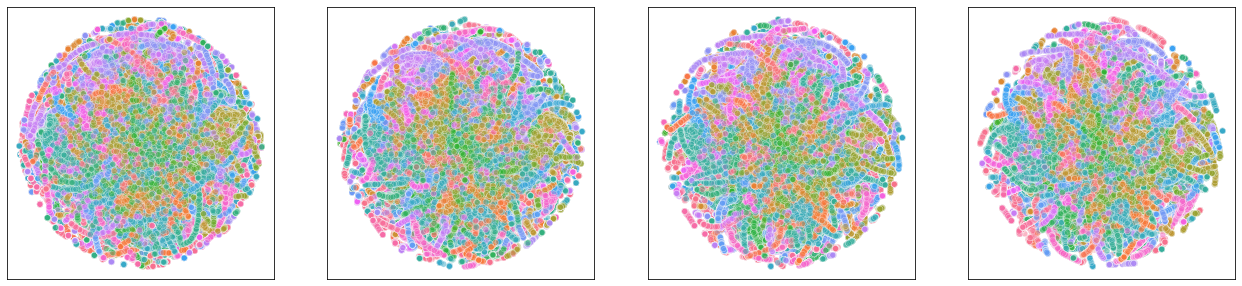

In [16]:
f, ax = plt.subplots(figsize=(22, 5), ncols= 4)

for i in range(4):
    df = tsne_150_wide.query("perplexity == '" + str([30,50,70,90][i]) + "'")
    g = sns.scatterplot(y="Axis_1", x="Axis_2", alpha=.5, hue= 'Topic', data = df, ax = ax[i])
    g.legend_.remove()
    g.tick_params(bottom = False, left = False)
    g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)



In [17]:
tsne_200_long = pd.melt(tsne_200, id_vars=['ProjectId','Topic'], value_vars=["TSNE_1_30", "TSNE_2_30","TSNE_1_50","TSNE_2_50","TSNE_1_70","TSNE_2_70", "TSNE_1_90","TSNE_2_90"])
tsne_200_long[['TSNE', 'TSNE_axis', 'perplexity']] = tsne_200_long.variable.str.split("_", expand=True)
tsne_200_long = tsne_200_long.drop(columns='TSNE')
tsne_200_wide = pd.pivot(tsne_200_long, index = ['ProjectId', 'Topic', 'perplexity'], columns='TSNE_axis', values='value').reset_index()
tsne_200_wide= tsne_200_wide.rename(columns={'1':'Axis_1', '2':'Axis_2'})
tsne_200_wide.head()

TSNE_axis     ProjectId Topic perplexity    Axis_1    Axis_2
0          ADP/2012/107   157         30  1.066998  7.219200
1          ADP/2012/107   157         50  0.253538  6.997184
2          ADP/2012/107   157         70 -0.911348  7.327199
3          ADP/2012/107   157         90 -1.058400  7.088178
4          ADP/2014/045    31         30  4.863239  0.673635

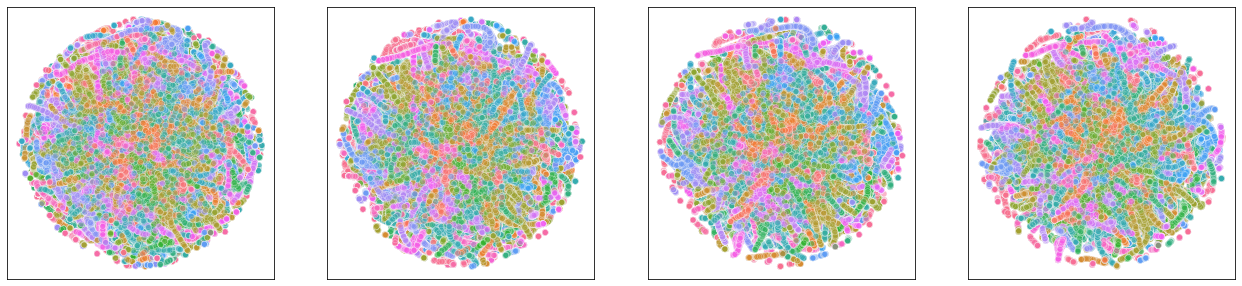

In [34]:
f, ax = plt.subplots(figsize=(22, 5), ncols= 4)

for i in range(4):
    df = tsne_200_wide.query("perplexity == '" + str([30,50,70,90][i]) + "'")
    g = sns.scatterplot(y="Axis_1", x="Axis_2", alpha=.5, hue= 'Topic', data = df, ax = ax[i])
    g.legend_.remove()
    g.tick_params(bottom = False, left = False)
    g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)


In [19]:
tsne_300_long = pd.melt(tsne_300, id_vars=['ProjectId','Topic'], value_vars=["TSNE_1_30", "TSNE_2_30","TSNE_1_50","TSNE_2_50","TSNE_1_70","TSNE_2_70", "TSNE_1_90","TSNE_2_90"])
tsne_300_long[['TSNE', 'TSNE_axis', 'perplexity']] = tsne_300_long.variable.str.split("_", expand=True)
tsne_300_long = tsne_300_long.drop(columns='TSNE')
tsne_300_wide = pd.pivot(tsne_300_long, index = ['ProjectId', 'Topic', 'perplexity'], columns='TSNE_axis', values='value').reset_index()
tsne_300_wide= tsne_300_wide.rename(columns={'1':'Axis_1', '2':'Axis_2'})
tsne_300_wide.head()

TSNE_axis     ProjectId Topic perplexity    Axis_1    Axis_2
0          ADP/2012/107   111         30  2.909671 -5.150925
1          ADP/2012/107   111         50  1.333619 -5.277291
2          ADP/2012/107   111         70  0.397016 -5.155528
3          ADP/2012/107   111         90 -0.183770 -4.872202
4          ADP/2014/045   111         30  4.484559 -5.025442

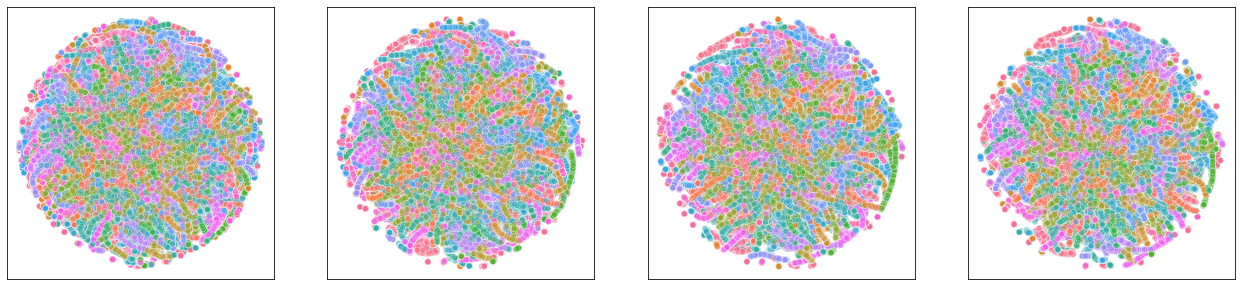

In [33]:
f, ax = plt.subplots(figsize=(22, 5), ncols= 4)

for i in range(4):
    df = tsne_300_wide.query("perplexity == '" + str([30,50,70,90][i]) + "'")
    g = sns.scatterplot(y="Axis_1", x="Axis_2", alpha=.5, hue= 'Topic', data = df, ax = ax[i])
    g.legend_.remove()
    g.tick_params(bottom = False, left = False)
    g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)

In [21]:
tsne_400_long = pd.melt(tsne_400, id_vars=['ProjectId','Topic'], value_vars=["TSNE_1_30", "TSNE_2_30","TSNE_1_50","TSNE_2_50","TSNE_1_70","TSNE_2_70", "TSNE_1_90","TSNE_2_90"])
tsne_400_long[['TSNE', 'TSNE_axis', 'perplexity']] = tsne_400_long.variable.str.split("_", expand=True)
tsne_400_long = tsne_400_long.drop(columns='TSNE')
tsne_400_wide = pd.pivot(tsne_400_long, index = ['ProjectId', 'Topic', 'perplexity'], columns='TSNE_axis', values='value').reset_index()
tsne_400_wide= tsne_400_wide.rename(columns={'1':'Axis_1', '2':'Axis_2'})
tsne_400_wide.head()

TSNE_axis     ProjectId Topic perplexity    Axis_1    Axis_2
0          ADP/2012/107   132         30  1.346367 -2.280483
1          ADP/2012/107   132         50  2.803500 -1.988743
2          ADP/2012/107   132         70  3.078572 -1.555722
3          ADP/2012/107   132         90  3.185227 -1.179229
4          ADP/2014/045    54         30 -0.391527  2.907048

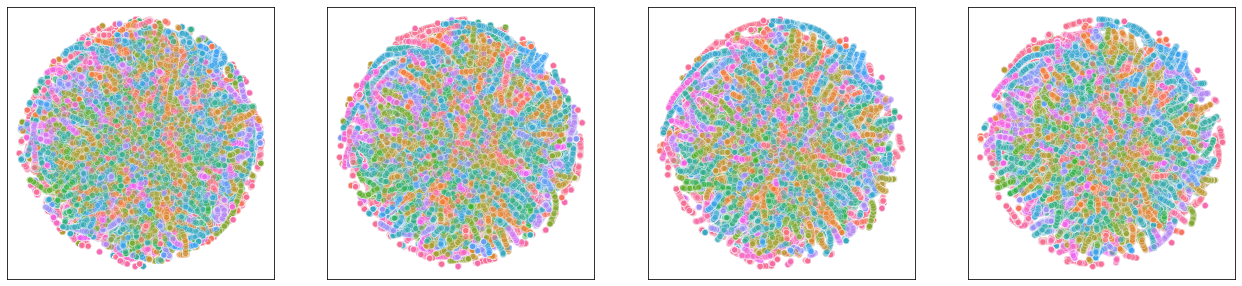

In [22]:
f, ax = plt.subplots(figsize=(22, 5), ncols= 4)

for i in range(4):
    df = tsne_400_wide.query("perplexity == '" + str([30,50,70,90][i]) + "'")
    g = sns.scatterplot(y="Axis_1", x="Axis_2", alpha=.5, hue= 'Topic', data = df, ax = ax[i])
    g.legend_.remove()
    g.tick_params(bottom = False, left = False)
    g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)

## TSNE with 5000 iterations

In [23]:
tsne_ite_5000 = pd.read_csv("/home/flavia/Projects/Funding-Landscape/results/fine-scale/tSNE/200-topics-TSNE_150.csv", index_col= False)
tsne_ite_5000["Topic"] = tsne_ite_5000.iloc[:, range(2,202)].idxmax(axis = "columns")

/tmp/ipykernel_172674/2583012094.py:1: DtypeWarning: Columns (205,206,207) have mixed types. Specify dtype option on import or set low_memory=False.
  tsne_ite_5000 = pd.read_csv("/home/flavia/Projects/Funding-Landscape/results/fine-scale/tSNE/200-topics-TSNE_150.csv", index_col= False)


In [24]:
# pivot long the data frame to get a column with the tsne perplexities
tsne_200_long_ite = pd.melt(tsne_ite_5000, id_vars=['ProjectId','Topic'], value_vars=["TSNE_1_50","TSNE_2_50","TSNE_1_150","TSNE_2_150"])
# split column name by '_' 
tsne_200_long_ite[['TSNE', 'TSNE_axis', 'perplexity']] = tsne_200_long_ite.variable.str.split("_", expand=True)
# drop column created by the first "_" in split
tsne_200_long_ite = tsne_200_long_ite.drop(columns='TSNE')
# pivot wide the dataframe to get axes
tsne_200_wide_ite = pd.pivot(tsne_200_long_ite, index = ['ProjectId', 'Topic', 'perplexity'], columns='TSNE_axis', values='value').reset_index()
# rename axes
tsne_200_wide_ite= tsne_200_wide_ite.rename(columns={'1':'Axis_1', '2':'Axis_2'})
# look at final df
tsne_200_wide_ite.head()

TSNE_axis     ProjectId Topic perplexity     Axis_1     Axis_2
0          ADP/2012/107   157        150  -8.230417  32.532908
1          ADP/2012/107   157         50   1.631488  34.222624
2          ADP/2014/045    31        150  29.771418  19.319141
3          ADP/2014/045    31         50   1.682450  31.012129
4           AH/2005/086   162        150  -6.037742  48.139953

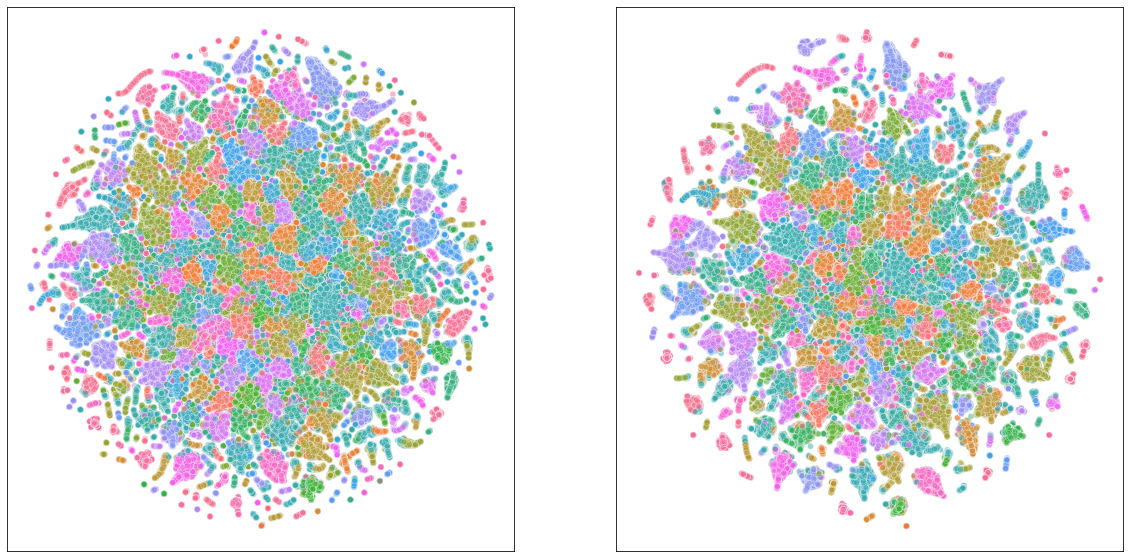

In [25]:
f, ax = plt.subplots(figsize=(20, 10), ncols= 2)

for i in range(2):
    df = tsne_200_wide_ite.query("perplexity == '" + str([50,150][i]) + "'")
    g = sns.scatterplot(y="Axis_1", x="Axis_2", alpha=.5, hue= 'Topic', data = df, ax = ax[i])
    g.legend_.remove()
    g.tick_params(bottom = False, left = False)
    g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)

In [26]:
# f, ax = plt.subplots(figsize=(20, 10), ncols= 2)

# for i in range(2):
#     df = tsne_200_wide_ite.query("perplexity == '" + str([50,150][i]) + "'")
#     g = sns.kdeplot(y="Axis_1", x="Axis_2", alpha=.5, levels=6, color = sns.color_palette()[0], fill= True, data = df, ax = ax[i])
#     # g.legend_.remove()
#     g.tick_params(bottom = False, left = False)
#     g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)

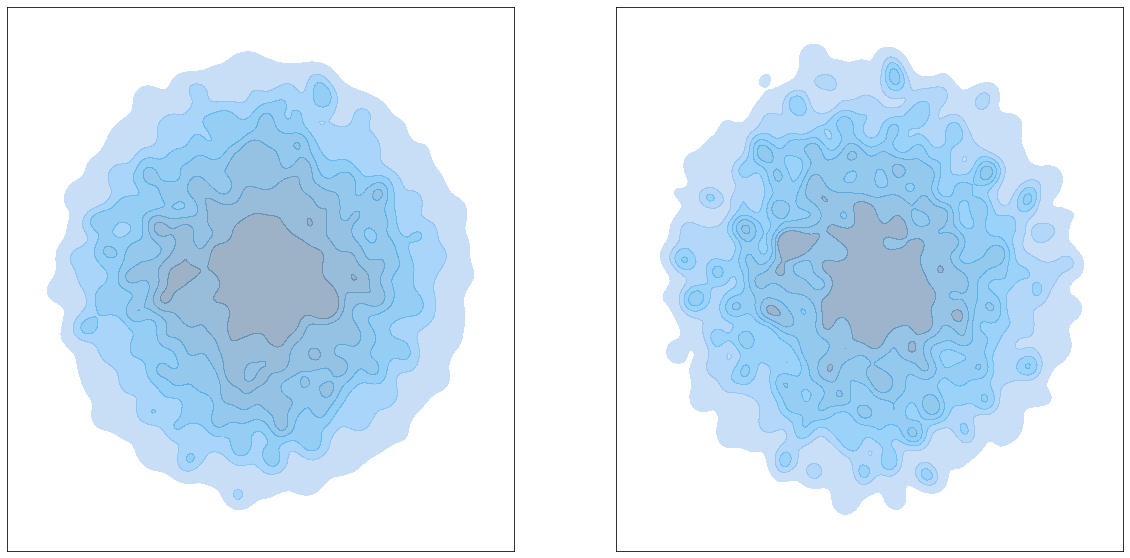

In [27]:
f, ax = plt.subplots(figsize=(20, 10), ncols= 2)

for i in range(2):
    df = tsne_200_wide_ite.query("perplexity == '" + str([50,150][i]) + "'")
    g = sns.kdeplot(y="Axis_1", x="Axis_2", alpha=.5, levels=8, color = sns.color_palette()[0], fill= True, data = df, ax = ax[i])
    # g.legend_.remove()
    g.tick_params(bottom = False, left = False)
    g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)

In [28]:
umap_150 = pd.read_csv('/home/flavia/Projects/Funding-Landscape/results/fine-scale/umap/150-topics-umap.csv', index_col=False)

/tmp/ipykernel_172674/3320827222.py:1: DtypeWarning: Columns (155,156,157) have mixed types. Specify dtype option on import or set low_memory=False.
  umap_150 = pd.read_csv('/home/flavia/Projects/Funding-Landscape/results/fine-scale/umap/150-topics-umap.csv', index_col=False)


In [29]:
umap_150.columns
umap_150["Topic"] = umap_150.iloc[:, range(2,152)].idxmax(axis = "columns")

In [30]:
# pivot long the data frame to get a column with the tsne perplexities
umap_150_long = pd.melt(umap_150, id_vars=['ProjectId','Topic'], value_vars=["UMAP_1_50","UMAP_2_50", "UMAP_1_75", "UMAP_2_75", "UMAP_1_100", "UMAP_2_100", "UMAP_1_150","UMAP_2_150", "UMAP_1_200", "UMAP_2_200"])
# split column name by '_' 
umap_150_long[['UMAP', 'UMAP_axis', 'n_neighbours']] = umap_150_long.variable.str.split("_", expand=True)
# drop column created by the first "_" in split
umap_150_long = umap_150_long.drop(columns='UMAP')
# pivot wide the dataframe to get axes
umap_150_wide = pd.pivot(umap_150_long, index = ['ProjectId', 'Topic', 'n_neighbours'], columns='UMAP_axis', values='value').reset_index()
# rename axes
umap_150_wide= umap_150_wide.rename(columns={'1':'Axis_1', '2':'Axis_2'})
# look at final df
umap_150_wide.head()

UMAP_axis     ProjectId Topic n_neighbours     Axis_1     Axis_2
0          ADP/2012/107    47          100   4.614143  11.495972
1          ADP/2012/107    47          150   6.279623  13.374776
2          ADP/2012/107    47          200   3.182742  10.070097
3          ADP/2012/107    47           50   4.112428  13.916437
4          ADP/2012/107    47           75  10.800822  10.476976

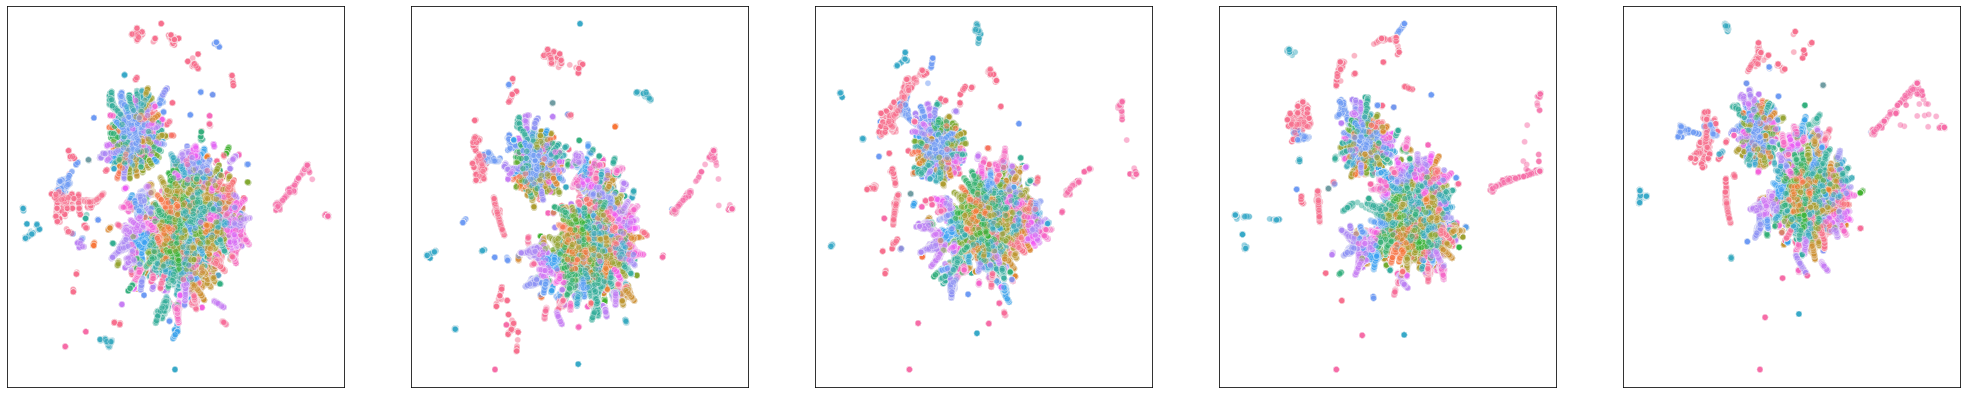

In [31]:
f, ax = plt.subplots(figsize=(35, 7), ncols= 5)

for i in range(5):
    df = umap_150_wide.query("n_neighbours == '" + str([50, 75, 100, 150, 200][i]) + "'")
    g = sns.scatterplot(y="Axis_1", x="Axis_2", alpha=.5, hue= 'Topic', data = df, ax = ax[i])
    # g = sns.kdeplot(y="Axis_1", x="Axis_2", alpha=.5, levels=8, color = sns.color_palette()[0], fill= True, data = df, ax = ax[i])
    g.legend_.remove()
    g.tick_params(bottom = False, left = False)
    g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)

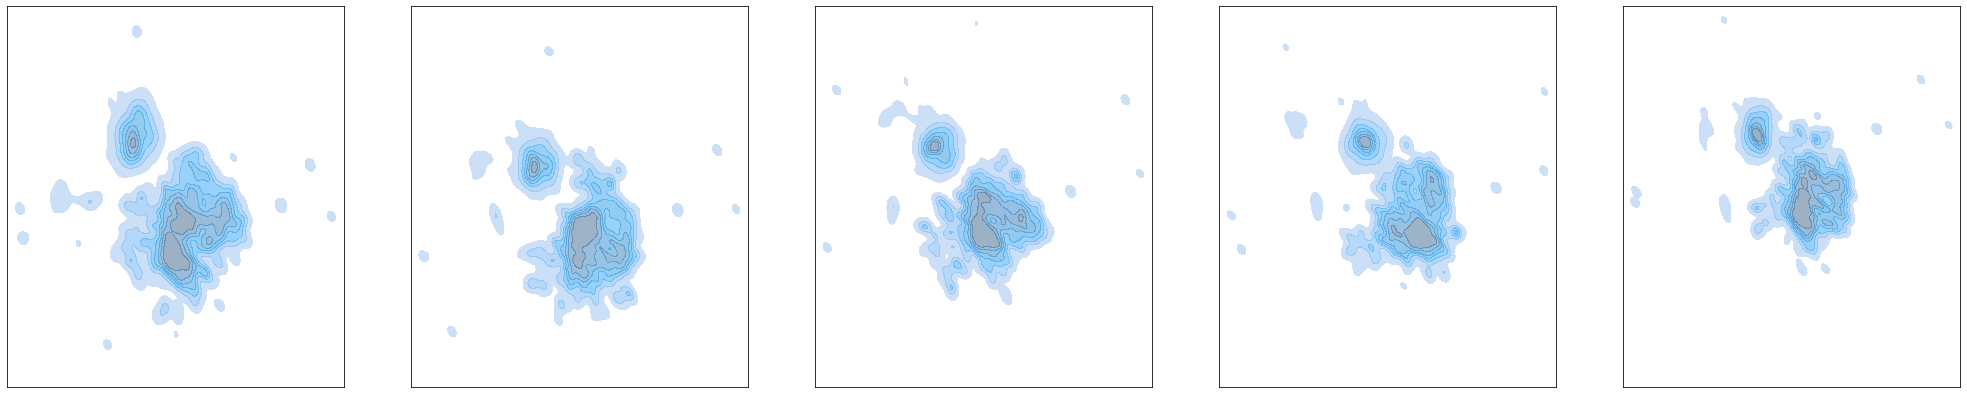

In [32]:
f, ax = plt.subplots(figsize=(35, 7), ncols= 5)

for i in range(5):
    df = umap_150_wide.query("n_neighbours == '" + str([50, 75, 100, 150, 200][i]) + "'")
    # g = sns.scatterplot(y="Axis_1", x="Axis_2", alpha=.5, hue= 'Topic', data = df, ax = ax[i])
    g = sns.kdeplot(y="Axis_1", x="Axis_2", alpha=.5, levels=8, color = sns.color_palette()[0], fill= True, data = df, ax = ax[i])
    # g.legend_.remove()
    g.tick_params(bottom = False, left = False)
    g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)